# Language Models (LMs)

#### Jan 2019
#### Philip Osborne 
#### version 1.0


See the corresponding Medium post for a full write-up with complete examples. Some of these code cells have been reduced in complexity to save run time which effects the output.

https://medium.com/@philiposbornedata/learning-nlp-language-models-with-real-data-cdff04c51c25

--------------------

#### Enable equation numbering in jupyter notebook for improved readability:

In [ ]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

# Introduction


# Part 1
--- 
## I. Probabilistic Language Models

### Example uses
- **Machine Translation:** P(**high** winds tonight) > P(**large** winds tonight)
- **Spell Correction:** P(...about fifteen **minutes** from...) > P(...about fifteen **mineuts** from...)
- **Speech Recognition:** P(I saw a van) >> P(eyes awe of an)

### Aim of Language Models
The goal of paobabilistic language modelling is to calculate the probability of a sentence of sequence of words: 

\begin{equation}
    P(W) = P(w_1,w_2,w_3,...,w_n)
\end{equation}

and can be used to find the probability of the next word in the sequence:

\begin{equation}
    P(w_5|w_1,w_2,w_3,w_4)
\end{equation}

a model that computes either of these is called a **language model (LM)**.

---
## II. Initial Method for Calcualting Probabilities

### Defn: Conditional Probability
Let A and B be two events with $P(B) \neq 0$, the conditional probability of A given B is:

\begin{equation}
    P(A|B) = \frac{P(A,B)}{P(B)}
\end{equation}

### Defn: Chain Rule
\begin{equation}
    P(x_1,x_2,...,x_n) = P(x_1)P(x_2|x_1)...P(x_n|x_1,...,x_{n-1})
\end{equation}

#### The Chain Rule applied to compute the join probability of words in a sentence:
\begin{equation}
    P(w_1 w_2 ... w_n) = \prod_{i} P(w_i|w_1 w_2 ... w_{i-1})
\end{equation}

e.g. 

P("its water is so transparent") =
    
    P(its)xP(water|its) 
    x P(is|its water) 
    x P(so|its water is) 
    x P(transparent|its water is so)

#### Can we estimate this by simply counting and dividing the results by the following?
\begin{equation}
    P(transparent|its \ water \ is \ so) = \frac{count(its \ water \ is \ so \ transparent)}{count(its \ water \ is \ so)}  
\end{equation}
#### NO! Far to many possible sentences that would need to be calculated, we would never have enough data to achieve this.


---
## III. Methods using the Markov Assumption

### Defn: Markov Property

*A stochastic process has the Markov property if the conditional probability distribution of future states of the process (conditional on both past and present states) depends only upon the present state, not on the sequence of events that preceded it. A process with this property is called a Markov process.* [1]

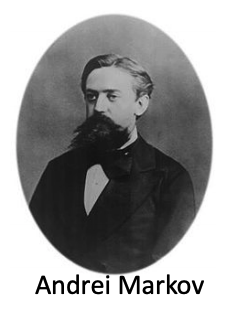
In other words, the probability of the next word can be estimated given only the previous $k$ number of words.

e.g. 

\begin{equation}
    P(transparent|its \ water \ is \ so) \approx P(transparent|so) 
\end{equation}
or


\begin{equation}
    P(transparent|its \ water \ is \ so) \approx P(transparent|is \ so) 
\end{equation}

#### General Equation for the Markov Assumption


\begin{equation}
    P(w_i|w_1 w_2 ... w_{i-1}) \approx P(w_i|w_{i-k} ... w_{i-1})
\end{equation}
where k is the number of words in the 'state' to be defined by the user.


### Unigram Model (k=1)

\begin{equation}
    P(w_1 w_2 ... w_n) \approx \prod_{i} P(w_i)
\end{equation}

### Bigram Model (k=2)

\begin{equation}
    P(w_i|w_1 w_2 ... w_{i-1}) \approx P(w_i|w_{i-1})
\end{equation}


---
## IV. N-gram Models (k=n)

The previous two equations can be extended to compute trigrams, 4-grams, 5-grams, etc. In general, this is an insufficient model of language because **sentences often have long distance dependencies**. For example, the subject of the sentence may be at the start whilst our next word to be predicited occurs more than 10 words later.

### Estimating Bigram Probabilities using the Maximum Likelihood Estimate
\begin{equation}
    P(w_i|w_{i-1}) = \frac{count(w_{i-1},w_i)}{count(w_{i-1})}
\end{equation}

#### Small Example

Three sentences:

- <s I am Sam /s>
- <s Sam I am /s>
- <s I do not like green eggs and ham /s>

\begin{equation}
P(I|<s) = \frac{count(<s,I)}{count(<s)} = \frac{2}{3}
\end{equation}


\begin{equation}
P(am|I) = \frac{count(I,am)}{count(I)} = \frac{2}{3}
\end{equation}



[1] https://en.wikipedia.org/wiki/Markov_property



# Example with Real Data


### Import Packages and IMDB Movie Review Data [2]


[2] http://ai.stanford.edu/~amaas/data/sentiment/

In [ ]:
import requests
import time

import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import re
import glob
import random
import seaborn as sns
import string

from IPython.display import clear_output

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# http://www.nltk.org/howto/wordnet.html

from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.wsd import lesk

In [ ]:
# Location of test/train data files on local computer, data downloaded directly from Stanford source[2]
#test_dir = '/Users/philiposborne/Documents/Written Notes/Learning Notes/IMDB Reviews/IMDB Data/test'
#train_dir = '/Users/philiposborne/Documents/Written Notes/Learning Notes/IMDB Reviews/IMDB Data/train'

data = pd.read_csv('imdb_master.csv',encoding="latin-1")


In [ ]:
data.head(20)

In [ ]:
# Select only training data
data = data[data['type']=='train'].reset_index(drop=True)

In [ ]:
data.head()

In [ ]:
print('Number of comments in data:', len(data))

data = data[0:1000]

print('Number of comments left in data after removal:', len(data))

In [ ]:
train_data = data

In [ ]:
# Data import written as a function:
# Replace test and train dir with correct path for file saved on local computer
# Data files are downloaded from reference link above where main file name is changed to IMDB Data

# This function converts the raw files form the original Stanford source into csv files.
'''
train_dir = "../LangAndComputer/aclImdb/train"
def IMDB_to_csv(directory):    
    data = pd.DataFrame()
    
    for filename in glob.glob(str(directory)+'/neg/*.txt'):
        with open(filename, 'r',  encoding="utf8") as f:
            content = f.readlines()
            content_table = pd.DataFrame({'id':filename.split('_')[0].split('/')[-1],'rating':filename.split('_')[1].split('.')[0],'pol':'neg', 'text':content})
        data = data.append(content_table)
        
    for filename in glob.glob(str(directory)+'/pos/*.txt'):
        with open(filename, 'r',  encoding="utf8") as f:
            content = f.readlines()
            content_table = pd.DataFrame({'id':filename.split('_')[0].split('/')[-1],'rating':filename.split('_')[1].split('.')[0],'pol':'pos', 'text':content})
        data = data.append(content_table)
    data = data.sort_values(['pol','id'])
    data = data.reset_index(drop=True)
    #data['rating_norm'] = (data['rating'] - data['rating'].min())/( data['rating'].max() - data['rating'].min() )

    return(data)

train_data = IMDB_to_csv(train_dir)

'''

In [ ]:
train_data.columns = ['id', 'dataset', 'text', 'pol','file']
train_data.head()

### We reduce the number of rows in our training corpus for learning purposes as the models take a substantial amout of time otherwise.

## Data Pre-processing

### 1. Convert full text comment into individual sentences

#### We can break the full text down into its individual sentences using the following:

In [ ]:
train_data['text'][0].split('.')

#### And can reference individual setences via indexing. We can also find the total number of sentences for each comment but it appears that the last setence is always blank. Therefore, when we use this in our loop, we reduce the upper index bound by 1 to account for this.


In [ ]:
train_data['text'][0].split('.')[0]

In [ ]:
len(train_data['text'][0].split('.'))

In [ ]:
train_data['text'][0].split('.')[8]

#### Using these, we break down our full commments into individual sentences. I have also introduced some methods for tracking and timing the progress of our for loops, for more info on these see the following:

[PhilipOsborneData.com link](https://www.philiposbornedata.com/2018/06/28/the-simplest-cleanest-method-for-tracking-a-for-loops-progress-and-expected-run-time-in-python-notebooks/)

[Medium.com link](https://towardsdatascience.com/the-simplest-cleanest-method-for-tracking-a-for-loops-progress-and-expected-run-time-in-python-972675392b3)
    

In [ ]:
train_data_sent = pd.DataFrame()

start_time = time.time()
for index in train_data.index:
    data_row = train_data.iloc[index,:]
    
    for sent_id in range(0,len(data_row['text'].split('.'))-1):
        sentence = data_row['text'].split('.')[sent_id]
        # Form a row in a dataframe for this setence that captures the words and keeps ids and polarity scores
        # We must pass an arbitrary index which we then reset to show unique numbers
        sentence_row = pd.DataFrame({
                                     'id':data_row['id'],
                                     'pol':data_row['pol'],
                                     'sent_id':sent_id,
                                     'sentence':sentence}, index = [index]) 
        
        # Form full table that has rows for all sentences
        train_data_sent = train_data_sent.append(sentence_row)
    
    
    # Outputs progress of main loop, see:
    clear_output(wait=True)
    print('Proportion of comments completed:', np.round(index/len(train_data),4)*100,'%')
    
end_time = time.time()
print('Total run time = ', np.round(end_time-start_time,2)/60, ' minutes')
# Reset index so that each index value is a unique number
train_data_sent = train_data_sent.reset_index(drop=True)
        

In [ ]:
train_data_sent.head(20)
#train_data_sent.shape

#### To simplify the process we remove all grammer and lowercase all words in the sentences.

#### We also add the string '<s' and '/s>' to the start and end of each sentence respectively so that we can find which words start and complete the sentences. 

In [ ]:
train_data_sent['sentence_clean'] = train_data_sent['sentence'].str.replace('[{}]'.format(string.punctuation), '')
train_data_sent['sentence_clean'] = train_data_sent['sentence_clean'].str.lower()

train_data_sent['sentence_clean'] = '<s ' + train_data_sent['sentence_clean']
train_data_sent['sentence_clean'] = train_data_sent['sentence_clean'] + ' /s>'

train_data_sent.head()

In [ ]:
text = train_data_sent['sentence_clean']

text_list = " ".join(map(str, text))
text_list[0:100]

#### Find the occurence of each word and use this to find the probability of occurence of each word

In [ ]:
word_list = pd.DataFrame({'words':text.str.split(' ', expand = True).stack().unique()})

In [ ]:
word_list.head(10)

In [ ]:
word_count_table = pd.DataFrame()
for n,word in enumerate(word_list['words']):
    # Create a list of just the word we are interested in, we use regular expressions so that part of words do not count
    # e.g. 'ear' would be counted in each appearance of the word 'year'
    word_count = len(re.findall(' ' + word + ' ', text_list))  
    word_count_table = word_count_table.append(pd.DataFrame({'count':word_count}, index=[n]))
    
    clear_output(wait=True)
    print('Proportion of words completed:', np.round(n/len(word_list),4)*100,'%')

word_list['count'] = word_count_table['count']
# Remove the count for the start and end of sentence notation so 
# that these do not inflate the other probabilities

## I commented out for the probability
#word_list['count'] = np.where(word_list['words'] == '<s' , 0,
#                     np.where(word_list['words'] == '/s>', 0,
#                     word_list['count']))

In [ ]:
word_list['prob'] = word_list['count']/sum(word_list['count'])
word_list.head(20)

---
---

### Unigram Model (k=1): $P(w_1 w_2 ... w_n) \approx \prod_{i} P(w_i)$

To apply this we can simply lookup the probability of each word in the sentence and then calculate the multiplicative product of these probabilities.

**Note for this notebook, I have reduced the number of items considered so that it runs in good time**


In [ ]:
unigram_table = pd.DataFrame()

start_time = time.time()
# Loop through each sentence
# REMOVE ROW LIMIT FOR FULL RUN
for index in train_data_sent[0:200].index:
    data_row = train_data_sent.iloc[index,:]
   
    sent_probs = pd.DataFrame()
    # Go through each word in the sentence, lookup the probability of the word and 
    # then find the mulitplicitive product of all probabilities in the sentence.
   

    ## I modified code for correction
    #for n,word in enumerate(data_row['sentence_clean']):    
    for n,word in enumerate(data_row['sentence_clean'].split(' ')):   
        #error corrected. We need iloc[0] to get a value
        sent_probs = sent_probs.append(pd.DataFrame({'prob':word_list[ word_list['words']== word]['prob'].iloc[0]}, index = [n]))
        
    unigram = sent_probs['prob'].prod(axis=0)
    
    # Create a list of unigram calculation for each sentence
    unigram_table = unigram_table.append(pd.DataFrame({'unigram':unigram},index = [index]))
    
    clear_output(wait=True)
    print('Proportion of sentences completed:', np.round(index/len(train_data_sent),4)*100,'%')
        
end_time = time.time()
print('Total run time = ', np.round(end_time-start_time,2)/60, ' minutes')

train_data_sent['unigram'] = unigram_table['unigram']

In [ ]:
base_time = end_time-start_time

In [ ]:
unigram_table.head(10)

In [ ]:
train_data_sent.head(10)

We can use logarithm space as addition is faster computationally than multiplications. 

As by log rules: $log(P1xP2xP3) = log(P1) + log(P2) + log(P3)$

In [ ]:
unigram_table_log = pd.DataFrame()

start_time_log = time.time()
# Loop through each sentence
# REMOVE ROW LIMIT FOR FULL RUN
for index in train_data_sent[0:200].index:
    data_row = train_data_sent.iloc[index,:]

    sent_probs = pd.DataFrame()
    # Go through each word in the sentence, lookup the probability of the word and 
    # then find the mulitplicitive product of all probabilities in the sentence.
    
    ## Same thing, I modified it because of enumerate 
    for n,word in enumerate(data_row['sentence_clean'].split(" ")):
        
        #error corectied
        log_prob = np.log10(word_list[ word_list['words']==word]['prob'].iloc[0])
        sent_probs = sent_probs.append(pd.DataFrame({'log_prob':log_prob}, index = [n]))
        
    unigram_log = np.sum(sent_probs['log_prob'], axis=0)
    #unigram_log = sum(sent_probs['log_prob'])
    #print(unigram_log)
    # Create a list of unigram calculation for each sentence
    unigram_table_log = unigram_table_log.append(pd.DataFrame({'unigram_log':unigram_log},index = [index]))
                                         
    clear_output(wait=True)
    print('Proportion of sentences completed:', np.round(index/len(train_data_sent),4)*100,'%')
                                                                   
end_time_log = time.time()
print('Total run time = ', np.round(end_time_log-start_time_log,2)/60, ' minutes')

train_data_sent['unigram_log'] = unigram_table_log['unigram_log']

In [ ]:
unigram_table_log.head(20)

In [ ]:
log_time = end_time_log - start_time_log

In [ ]:
print('The log base 10 method takes approximately ', np.round((log_time)/base_time,4)*100, '% of the time of the orginal calculation.')

In [ ]:
train_data_sent.head(20)

In [ ]:
print(10**-43.797963)

#### The unigram model can be similarly used to find the estimated probability of two (or more words) occuring in sequence.

For example, we can compute the probability of words 'to' and 'a' occuring:

In [ ]:
word_1 = 'to'
word_2 = 'a'

prob_word_1 = word_list[word_list['words'] == word_1]['prob'].iloc[0]
prob_word_2 = word_list[word_list['words'] == word_2]['prob'].iloc[0]

unigram_prob = prob_word_1*prob_word_2

print('The unigram probability of the word "a" occuring given the word "to" was the previous word is: ', np.round(unigram_prob,10))

### Bigram Model (k=2): $P(w_i|w_1 w_2 ... w_{i-1}) \approx P(w_i|w_{i-1})$

Applying this is somewhat more complex, first we find the co-occurances of each word into a word-word matrix. The counts are normalised by the counts of the previous word: 

\begin{equation}
P(w_i|w_{i-1}) \approx \frac{count(w_{i-1},w_i)}{count(w_{i-1})}
\end{equation}


So, for example, if we wanted to find the P(a|to) we first count the occurances of (to,a) and divide this by the count of (to):


In [ ]:
word_1 = ' ' + str('to') + ' '
word_2 = str('a') + ' '

bigram_prob = len(re.findall(word_1 + word_2, text_list)) / len(re.findall(word_1, text_list)) 

print('The probability of the word "a" occuring given the word "to" was the previous word is: ', np.round(bigram_prob,5))

and likewise, if we change the previous word to 'has':

In [ ]:
word_1 = ' ' + str('has') + ' '
word_2 = str('a') + ' '

bigram_prob = len(re.findall(word_1 + word_2, text_list)) / len(re.findall(word_1, text_list)) 

print('The probability of the word "a" occuring given the word "has" was the previous word is: ', np.round(bigram_prob,5))

We can repeat this calculation for all word pairs to find the most likely word to follow the given word. This of course takes an exceptional amount of time and it may be better to compute this for words as required rather than attempting to do it for all. 

In [ ]:
W_W_Matrix = pd.DataFrame({'words': word_list['words']})


start_time = time.time()


# Add limits to number of columns/rows so this doesn't run for ages
column_lim = 1000
#column_lim = len(W_W_Matrix)
row_lim = 10
#row_lim = len(W_W_Matrix)

for r, column in enumerate(W_W_Matrix['words'][0:column_lim]):
    
    prob_table = pd.DataFrame()
    for i, row in enumerate(W_W_Matrix['words'][0:row_lim]):
        #print(row)
        word_1 = ' ' + str(row) + ' '
        word_2 = str(column) + ' '

        if len(re.findall(word_1, text_list)) == 0:
            prob = pd.DataFrame({'prob':[0]}, index=[i])
        else:
            prob = pd.DataFrame({'prob':[len(re.findall(word_1 + word_2, text_list)) / len(re.findall(word_1, text_list)) ]}, index=[i])
        
        prob_table = prob_table.append(prob)
    W_W_Matrix[str(column)] = prob_table['prob']
    
    # Outputs progress of main loop, see:
    clear_output(wait=True)
    print('Proportion of column words completed:', np.round(r/len(W_W_Matrix[0:column_lim]),2)*100,'%')
    
end_time = time.time()
print('Total run time = ', np.round(end_time-start_time,2)/60, ' minutes')


In [ ]:
W_W_Matrix[W_W_Matrix['a'] >= 0]

In [ ]:
for i in range(0,row_lim):
    plt.bar(W_W_Matrix.iloc[i,1:].sort_values(ascending=False)[1:10].index,W_W_Matrix.iloc[i,1:].sort_values(ascending=False)[1:10].values)
    plt.title('Most Common Words that Follow the word: ' +str(W_W_Matrix.iloc[i,0]))
    plt.show()

These can be used to form sentences, if we calculate the bigram probabilities 'on the fly' we can find the next most likely word for the given word. To ensure that different sentences are form, we vary the selected colmuns randomly.

Fixing the start and end of the sentence to be the respective <s and /s> notations, we form the following:

**NOTE I have made the word cap very small as this takes a significant time to run (2 hours for 5 words) but an example output is shown.**


In [ ]:
W_W_Matrix = pd.DataFrame({'words': word_list['words']})

start_time = time.time()

text_list = " ".join(map(str, text))

# Increasing these take significant time to run but provide more realistic sentences
num_sentences = 1
sentence_word_limit = 1

#extract start and end of sentence notation so that they are always included
sentence_forms = W_W_Matrix[(W_W_Matrix['words']=='<s') | (W_W_Matrix['words']=='/s>')]['words']

sentences_output = pd.DataFrame()
for sample in range(0,num_sentences):
    
    sentence = pd.DataFrame()
    
    for i in range(0,sentence_word_limit):
        # if this is the first word, fix it to be start of sentence notation else take output of previous iteration
        if (i==0):
            current_word = str('<s')
        # Randomly select first word after sentence start
        elif (i==1):
            current_word = str(W_W_Matrix[(W_W_Matrix['words']!='<s') ]['words'].sample(1, axis=0).iloc[0])
        else:
            current_word = next_word
        
        sentence['word_'+str(i)] = [current_word]
        # if we have reached end of sentence, add this sentence to output table and break loop to start new sentence
        if (current_word==str('/s>')):
            sentences_output = sentences_output.append(sentence)
            break   
        else:
            
            prob_table = pd.DataFrame()

            # randomly select other words form rest of list
            for r, column in enumerate(W_W_Matrix[(W_W_Matrix['words']!='<s') ]['words'].reset_index(drop=True)):

                next_words = str(column)



                if len(re.findall(' ' + current_word + ' ', text_list)) == 0:
                    prob = pd.DataFrame({'word':str(column),
                        'prob':[0]}, index=[i])
                else:
                    prob = pd.DataFrame({'word':str(column),
                        'prob':[len(re.findall(' ' + current_word + ' ' + next_words + ' ', text_list)) / len(re.findall(' ' + current_word + ' ', text_list)) ]}, index=[i])

                prob_table = prob_table.append(prob)
                # We can reduce the probability of the sentence ending so that we return longer sentences
                reduce_end_prob = 0.5
                prob_table['prob'] = np.where(prob_table['word']=='/s>', prob_table['prob']*reduce_end_prob,prob_table['prob'])
                # next word is most probable of this given the current word
                next_word = prob_table[prob_table['prob'] == max(prob_table['prob'])]['word'].reset_index(drop=True).iloc[0]
                
                # Outputs progress of main loop:
                clear_output(wait=True)
                print("Sentence number: ",sample+1)
                print("Words completed in current sentence:",i+1)
                print('Proportion of column words completed:', np.round(r/len(W_W_Matrix),2)*100,'%')

        
end_time = time.time()
print('Total run time = ', np.round(end_time-start_time,2)/60, ' minutes')


In [ ]:
for i in range(1,num_sentences):
    print('Sentence ',i,':',sentences_output.iloc[i].values)

Sample output sentence:

Sentence  0 : ['<s' 'root' 'for' 'the' 'movie' '/s>']

and we can manually explore each probability, for example:


In [ ]:
word_1 = str('for')
word_2 = str('the') 

bigram_prob = len(re.findall(' ' + word_1 + ' ' + word_2 + ' ', text_list)) / len(re.findall(' ' + word_1 + ' ', text_list))


print('The probability of the word "',word_2,'" occuring given the word "',word_1,'" was the previous word is: ', (bigram_prob))

### Tri-grams and beyond!

If we continue the estimation equation for trigrams, we have the following:

\begin{equation}
    P(x_3|x_1,x_2) \approx \frac{count(x_1,x_2,x_3)}{count(x_1,x_2)}
\end{equation}

In [ ]:
word_1 = str('to')
word_2 = str('a') 
word_3 = str('movie')

trigram_prob = (len(re.findall(' ' + word_1 + ' ' + word_2 + ' ' + word_3 + ' ', text_list)) / 
                    len(re.findall(' ' + word_1 + ' ' + word_2, text_list)))


print('The probability of the word "',word_3,'" occuring given the word "',word_1,'" and "',word_2,'" were the previous two words is: ', (trigram_prob))

In [ ]:
word_1 = str('to')
word_2 = str('a') 
word_3 = str('film')

trigram_prob = (len(re.findall(' ' + word_1 + ' ' + word_2 + ' ' + word_3 + ' ', text_list)) / 
                    len(re.findall(' ' + word_1 + ' ' + word_2, text_list)))


print('The probability of the word "',word_3,'" occuring given the word "',word_1,'" and "',word_2,'" were the previous two words is: ', (trigram_prob))

#### Therefore, trigram phrase 'to a movie' is used more commonly than 'to a film' and is the choice our algorithm would take when forming sentences.

The code to systemtically find the most likely next word and form sentences with trigrams can be repeated following the previous bigram computations. 

---
---
# Part 2
---
## V. Training and Testing the Language Models (LMs)

The corpus used to train our LMs will impact the output predictions. Therefore we need to introduce a methodology for evaluating how well our trained LMs perform. The best trained LM is the one that can correctly **predict the next word of setences in an unseen test set.**

This can be time consuming, to build multiple LMs for comparison could take hours to compute. Therefore, we introduce the intrinsic evaluation method of **perplexity**. In short perplexity is a measure of how well a probability distribution or probability model predicts a sample. [3]

### Defn: Perplexity

Perplexity is the inverse probability of the test set normalised by the number of words, more specifically can be defined by the following equation:

\begin{equation}
    PP(W) = P(w_1 w_2 ... w_N)^{\frac{-1}{N}}
\end{equation}

e.g. Suppose a sentence consists of random digits [0-9], what is the perplexit of this sentence by a model that asigns an equal probability (i.e. $P = 1/10$) to each digit?

\begin{equation}
    PP(W) = (\frac{1}{10}*\frac{1}{10}*...*\frac{1}{10})^{\frac{-1}{10}} = (\frac{1}{10}^{10} )^{\frac{-1}{10}} = \frac{1}{10}^{-1} = 10
\end{equation}


--
## VI. Entropy in Mechanics and Information Theory

In mechanics, Boltsmann defined the entropy of a system is related to the natural log of the number of microstates:

\begin{equation}
    S = klnW \ where \ k = 1.3x10^{-23}
\end{equation}

W is the number of microstates and is calculated by:

\begin{equation}
    W = n^x
\end{equation}

where n is the number of positions and x is the number of molecules.


In Information Theory, entropy (denoted $H(X)$) of a random variable X is the expected log probabiltiy:

\begin{equation}
    H(X) = - \sum P(x)log_2 P(x)
\end{equation}

and is a measure of uncertainty. [4]

#### In other words, entropy is the number of possible states that a system can be.

### Entropy of a bias coin toss

Say we have the probabilities of heads and tails in a coin toss defined by:

- $P(heads) = p$
- $P(tails) = 1-p$

Then the entropy of this is:

\begin{equation}
    H(X) = - \sum P(x)log_2 P(x) = -[plog_2 p + (1-p)log_2 (1-p)]
\end{equation}

If the coin is fair, i.e. p = 0.5, then we have:

\begin{equation}
    H(X) = -[0.5log_2 0.5 + (1-0.5)log_2 (1-0.5)] = -[-0.5-0.5] = 1
\end{equation}

The full entropy distibution over varying bias probabilities is shown below.


[3] https://en.wikipedia.org/wiki/Perplexity
[4] https://en.wikipedia.org/wiki/Entropy_(information_theory)

In [ ]:
p = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
H = [-(p*np.log2(p) + (1-p)*np.log(1-p)) for p in p]
# Replace nan output with 0 
H = [0 if math.isnan(x) else x for x in H]

plt.plot(p,H)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1])
plt.xlabel('Probability of Heads (p)')
plt.ylabel('Entropy (H(p))')
plt.title('The Entropy of a Bias Coin as \n the Probabilitiy of Heads Varies')

---
## VII. Entropy of Language

### 1. Entropy of a sequence of words:

\begin{equation}
    H(w_1 w_2 ... w_n) = - \sum_{w_1...wn} P(w_1 ... w_n) log_2 P(w_1 ... w_n)
\end{equation}

### 2. The per-word entropy rate of a sequence of words

\begin{equation}
    \frac{1}{n} H(w_1 w_2 ... w_n) = \frac{-1}{n} \sum_{w1...wn} P(w_1 ... w_n) log_2 P(w_1 ... w_n),2)
\end{equation}

### 3. Entropy of a language $L = \{w_1 ... w_n | 1 < n < \infty\}$:

\begin{equation}
    H(L) = - \lim_{n\to\infty} \frac{1}{n} H(w_1 ... w_n)
\end{equation}


### Defn: Cross Entropy

The cross entropy, H(p,m), of a true distribution **p** and a model distribution **m** is defined as:

\begin{equation}
    H(p,m) = - \sum_{x} p(x) log_2 m(x)
\end{equation}

The lower the cross entropy is the closer it is to the true distribution.

### Defn: Cross Entropy of a Sequence of Words

\begin{equation}
    H(p,m) = - \lim_{n\to\infty} \frac{1}{n} \sum_{w1...wn} p(w_1 ... w_n) log_2 m(w_1 ... w_n)
\end{equation}

---
## VIII. Perplexity and Entropy

\begin{equation}
PP(w_1 ... w_N) = 2^{H(w_1 ... w_N)}
\end{equation}




In [ ]:
sent_1 = text.iloc[0]
sent_2 = text.iloc[1]

print('Sentence 1', sent_1)
print('--.--.--.--.--.--.--.--')
print('Sentence 2', sent_2)

In [ ]:
data_prob = word_list[['words','count','prob']]
data_prob.head()

In [ ]:
def entropy(sentence, data_prob):
    entropy_table = pd.DataFrame()
    for n,word in enumerate(sentence.split(' ')):
        # log2(0) provide nan so return 0 instead
        if ((data_prob[data_prob['words']==word]['prob'].iloc[0]) == 0):
            entropy = 0
        else:
            prob = data_prob[data_prob['words']==word]['prob'].iloc[0]
            entropy = prob*np.log2(prob)
        entropy_table = entropy_table.append(pd.DataFrame({'word':word,
                                                            'entropy':entropy}, index = [n]))
    phrase_entropy = -1*sum(entropy_table['entropy'])
    return(phrase_entropy)

In [ ]:
sent_1_entropy = entropy(sent_1,data_prob)
sent_2_entropy = entropy(sent_2,data_prob)

print('Sentence 1: ', sent_1)
print('Sentence 1 entropy: ', np.round(sent_1_entropy,5))
print('Per-word Sentence 1 entropy: ', np.round(sent_1_entropy/len(sent_1.split(' ')),5))

print('--.--.--.--.--.--.--.--')
print('Sentence 2: ', sent_2)
print('Sentence 2 entropy: ', np.round(sent_2_entropy,5))
print('Per-word Sentence 2 entropy: ', np.round(sent_2_entropy/len(sent_2.split(' ')),5))


### Likewise, we can calculate the perplexity of each sentence:

In [ ]:
sent_1_perplex = 2**sent_1_entropy
sent_2_perplex = 2**sent_2_entropy

print('Sentence 1: ', sent_1)
print('Sentence 1 entropy: ', np.round(sent_1_entropy,5))
print('Per-word Sentence 1 entropy: ', np.round(sent_1_entropy/len(sent_1.split(' ')),5))
print('Sentence 1 Perplexity: ', sent_1_perplex)

print('--.--.--.--.--.--.--.--')
print('Sentence 2: ', sent_2)
print('Sentence 2 entropy: ', np.round(sent_2_entropy,5))
print('Per-word Sentence 2 entropy: ', np.round(sent_2_entropy/len(sent_2.split(' ')),5))
print('Sentence 2 Perplexity: ', sent_2_perplex)


Which we can use to find the probability of the whole sentence as:
    
\begin{equation}
    PP(W) = P(w_1 w_2 ... w_N)^{\frac{-1}{N}}
\end{equation}


In [ ]:
sent_1_prob = (1/sent_1_perplex)**len(sent_1.split(' '))
sent_2_prob = (1/sent_2_perplex)**len(sent_2.split(' '))

print('Sentence 1 Probability: ', '%0.10f' % sent_1_prob)
print('Sentence 2 Probability: ', '%0.10f' % sent_2_prob  )

---
---

# Part 3
---
## Challenges in Fitting LMs

Due to the output of LMs is dependent on the training corpus, N-grams only work well if the training corpus is similar to the testing dataset and we risk overfitting in training. 

As with any machine learning method, we would like results that are generalisable to new information. 

Even harder is how we deal with words that do not even appear in training but are in the test data. 

## IX. Dealing with Zero Counts in Training: Laplace +1 Smoothing

To deal with words that are unseen in training we can introduce add-one smoothing. To do this, we simply add one to the count of each word.

This shifts the distribution slightly and is often used in text classification and domains where the number of zeros isn't large. However, this is not often used for n-grams, instead we use more complex methods. 




First, let us create a dummy training corpus and test set from the original data:

In [ ]:
train_data_sent.head()

In [ ]:
corpus = train_data_sent['sentence_clean'][:int(np.round(len(train_data_sent)*0.9,0))]
test = train_data_sent['sentence_clean'][int(np.round(len(train_data_sent)*0.9,0))+1:]

corpus_list = " ".join(map(str, corpus))
test_list = " ".join(map(str, test))


In [ ]:
# Corpus word probabilities
corpus_word_list = pd.DataFrame({'words':corpus.str.split(' ', expand = True).stack().unique()})
corpus_word_count_table = pd.DataFrame()
for n,word in enumerate(corpus_word_list['words']):
    # Create a list of just the word we are interested in, we use regular expressions so that part of words do not count
    # e.g. 'ear' would be counted in each appearance of the word 'year'
    corpus_word_count = len(re.findall(' ' + word + ' ', corpus_list))  
    corpus_word_count_table = corpus_word_count_table.append(pd.DataFrame({'count':corpus_word_count}, index=[n]))
    
    clear_output(wait=True)
    print('Proportion of words completed:', np.round(n/len(corpus_word_list),4)*100,'%')

corpus_word_list['count'] = corpus_word_count_table['count']
# Remove the count for the start and end of sentence notation so 
# that these do not inflate the other probabilities
corpus_word_list['count'] = np.where(corpus_word_list['words'] == '<s' , 0,
                     np.where(corpus_word_list['words'] == '/s>', 0,
                     corpus_word_list['count']))
corpus_word_list['prob'] = corpus_word_list['count']/sum(corpus_word_list['count'])





In [ ]:
corpus_word_list.head()


In [ ]:
# Test set word probabilities
test_word_list = pd.DataFrame({'words':test.str.split(' ', expand = True).stack().unique()})
test_word_count_table = pd.DataFrame()
for n,word in enumerate(test_word_list['words']):
    # Create a list of just the word we are interested in, we use regular expressions so that part of words do not count
    # e.g. 'ear' would be counted in each appearance of the word 'year'
    test_word_count = len(re.findall(' ' + word + ' ', test_list))  
    test_word_count_table = test_word_count_table.append(pd.DataFrame({'count':test_word_count}, index=[n]))
    
    clear_output(wait=True)
    print('Proportion of words completed:', np.round(n/len(test_word_list),4)*100,'%')

test_word_list['count'] = test_word_count_table['count']
# Remove the count for the start and end of sentence notation so 
# that these do not inflate the other probabilities
test_word_list['count'] = np.where(test_word_list['words'] == '<s' , 0,
                     np.where(test_word_list['words'] == '/s>', 0,
                     test_word_list['count']))
test_word_list['prob'] = test_word_list['count']/sum(test_word_list['count'])



In [ ]:
test_word_list.head()

In [ ]:
# Merge corpus counts to test set and replace missing values with 0
test_word_list_2 = test_word_list.merge(corpus_word_list[['words','count']], how='left', on = 'words')
test_word_list_2['count_y'].fillna(0, inplace=True)

test_word_list_2.head()

In [ ]:
print('Percentage of words in test set that are not contained in corpus',len(test_word_list_2[test_word_list_2['count_y']==0])/len(test_word_list_2)*100,'%')

In [ ]:
# Extract missing words from training set
missing_words = test_word_list_2[test_word_list_2['count_y']==0]
missing_words = missing_words[(missing_words['words']!='<s')&(missing_words['words']!='/s>')]
missing_words = missing_words[['words']]
missing_words['count'] = 0
missing_words['prob'] = 0
missing_words.head()

### Adjusted Counting

- I added Adjusted count for better understanding
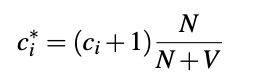

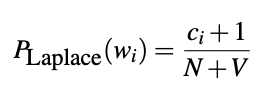

In [ ]:
# Add missing words onto end of corpus word list and apply laplace +1 smoothing
corpus_word_list_fixed = corpus_word_list.append(missing_words)

corpus_word_list_fixed['count+1'] = corpus_word_list_fixed['count']+1
corpus_word_list_fixed['prob+1'] = corpus_word_list_fixed['count+1']/sum(corpus_word_list_fixed['count+1'])
corpus_word_list_fixed['adjustedCount'] = corpus_word_list_fixed['count+1'] *(sum(corpus_word_list_fixed['count']) / (sum(corpus_word_list_fixed['count'])+ len(corpus_word_list_fixed)))
corpus_word_list_fixed['checkProb'] = corpus_word_list_fixed['count+1'] / (sum(corpus_word_list_fixed['count'])+ len(corpus_word_list_fixed))
corpus_word_list_fixed.head(100)

In [ ]:
# Plot distribution before and after Laplace +1 Smoothing
sns.distplot(corpus_word_list_fixed[corpus_word_list_fixed['count']<=15]['count'], label='Before')
sns.distplot(corpus_word_list_fixed[corpus_word_list_fixed['count']<=15]['count+1'], label='After +1 Smoothing')

plt.legend()
plt.title('Distribution of Word Counts Before/After \n Laplace +1 Smoothing')
plt.xlabel('Word Count Bin')
plt.ylabel('Count')
plt.show()

### X. Futher Smoothing Methods

Laplace +1 smoothing is used in text classification and domains where the number of zeros isn't large. However, it is not often used for n-grams, some better smothing methods for n-grams are:

- Add-k Laplace Smoothing
- Good-Turing
- Kenser-Ney
- Witten-Bell


---
---
# Part 4

## Selecting the Language Model to Use

We have introduced the first three LMs (unigram, bigram and trigram) but which is best to use?

Trigrams are generally provide better outputs than bigrams and bigrams provide better outputs than unigrams but as we increase the complexity the computation time becomes increasingly large. Furthermore, the amount of data available decreases as we increase n (i.e. there will be far fewer next words available in a 10-gram than a bigram model).

## XI. Back-off Method: Use trigrams (or higher n model) if there is good evidence to, else use bigrams (or other simpler n-gram model).

## XII. Interpolation: Use a mixture of n-gram models

### Defn: Simple Interpolation:

\begin{equation}
    P(w_3|w_1,w_2) = \lambda_1 P(w3|w_1,w_2) + \lambda_2 P(w_3|w_2) + \lambda_3 P(w_3)
\end{equation}

where $\sum_{i} \lambda_i = 1$.

### Defn: Contidional Context Interpolation:

\begin{equation}
    P(w_3|w_1,w_2) = \lambda_1 (w_{1}^{2})P(w3|w_1,w_2) + \lambda_2 (w_{1}^{2})P(w_3|w_2) + \lambda_3 (w_{1}^{2})P(w_3)
\end{equation}


### Calculating $\lambda$s:

Using a held-out subset of the corpus (validation set), find $\lambda$s that maximise the probability of the held out data:

\begin{equation}
    P(w_1,w_2,...,w_n|M(\lambda_1,\lambda_2,...,\lambda_k)) = \sum_i log P_{M(\lambda_1,\lambda_2,...,\lambda_k)}(w_i|w_{i-1})
\end{equation}

Where unknown words are assigned an unknown word token '<Ukn'.


### Small Interpolation Example

Say we are given the following corpus:

- <s I am Sam /s>
- <s Sam I am /s>
- <s I am Sam /s>
- <s I do not like green eggs and Sam /s>

Using linear interpolation smoothing with a bigram and unigram model with $\lambda_1 = \frac{1}{2}$ and $\lambda_2 = \frac{1}{2}$, what is $P(Sam|am)$? (note: include '<s' and '/s>' in calculations)

Using the following equation:

\begin{equation}
    P(w_2|w_1) = lambda_1 P(w_2|w1) + lambda_2 P(w2)
\end{equation}

We have in our case:

\begin{equation}
    P(Sam|am) = \frac{1}{2} P(Sam|am) + \frac{1}{2} P(Sam)
\end{equation}

where 

\begin{equation}
    P(Sam|am) = \frac{count(am, Sam)}{count(am)} = \frac{2}{3}
\end{equation}

and

\begin{equation}
    P(Sam) = \frac{count(Sam)}{Total \ num \ words} = \frac{4}{25}
\end{equation}

Therefore,

\begin{equation}
    P(Sam|am) = \frac{1}{2}*\frac{2}{3} + \frac{1}{2}*\frac{4}{25} \approx 0.413
\end{equation}



### Interpolation Example with IMDB Data

Say we start with the corpus defined in the previous part, we again take a small subset of this as the 'hold-out' set.

In [ ]:
corpus.head()

In [ ]:
corpus_2 = corpus[:int(np.round(len(corpus)*0.9,0))]
hold_out = corpus[int(np.round(len(corpus)*0.9,0))+1:]

corpus_2_list = " ".join(map(str, corpus_2))
hold_out_list = " ".join(map(str, hold_out))


In [ ]:
hold_out.head()
#hold_out_word_list = pd.DataFrame({'words':hold_out.str.split(' ', expand = True).stack().unique()})
#hold_out_word_list.head(20)

In [ ]:
# hold out set word probabilities
hold_out_word_list = pd.DataFrame({'words':hold_out.str.split(' ', expand = True).stack().unique()})
hold_out_word_count_table = pd.DataFrame()
for n,word in enumerate(hold_out_word_list['words']):
    # Create a list of just the word we are interested in, we use regular expressions so that part of words do not count
    # e.g. 'ear' would be counted in each appearance of the word 'year'
    hold_out_word_count = len(re.findall(' ' + word + ' ', hold_out_list))  
    hold_out_word_count_table = hold_out_word_count_table.append(pd.DataFrame({'count':hold_out_word_count}, index=[n]))
    
    clear_output(wait=True)
    print('Proportion of words completed:', np.round(n/len(hold_out_word_list),4)*100,'%')

hold_out_word_list['count'] = hold_out_word_count_table['count']
# Remove the count for the start and end of sentence notation so 
# that these do not inflate the other probabilities
hold_out_word_list['count'] = np.where(hold_out_word_list['words'] == '<s' , 0,
                     np.where(hold_out_word_list['words'] == '/s>', 0,
                     hold_out_word_list['count']))
hold_out_word_list['prob'] = hold_out_word_list['count']/sum(hold_out_word_list['count'])



In [ ]:
hold_out_word_list.head(100)

In [ ]:
hold_out_Matrix = pd.DataFrame({'words': hold_out_word_list['words']})

start_time = time.time()


# Add limits to number of columns/rows so this doesn't run for ages
column_lim = 100
#column_lim = len(W_W_Matrix)
row_lim = 10
#row_lim = len(W_W_Matrix)

for r, column in enumerate(hold_out_Matrix['words'][0:column_lim]):
    
    prob_table = pd.DataFrame()
    for i, row in enumerate(hold_out_Matrix['words'][0:row_lim]):

        word_1 = ' ' + str(row) + ' '
        word_2 = str(column) + ' '

        if len(re.findall(word_1, hold_out_list)) == 0:
            prob = pd.DataFrame({'prob':[0]}, index=[i])
        else:
            prob = pd.DataFrame({'prob':[len(re.findall(word_1 + word_2, hold_out_list)) / len(re.findall(word_1, hold_out_list)) ]}, index=[i])
        
        prob_table = prob_table.append(prob)
    hold_out_Matrix[str(column)] = prob_table['prob']
    
    # Outputs progress of main loop, see:
    clear_output(wait=True)
    print('Proportion of column words completed:', np.round(r/len(hold_out_Matrix[0:column_lim]),2)*100,'%')
    
end_time = time.time()
print('Total run time = ', np.round(end_time-start_time,2)/60, ' minutes')


In [ ]:
hold_out_Matrix.head(10)

In [ ]:
hold_out_Matrix['words'] = hold_out_word_list['words']

#### The matrix defines the probability of the column given the row (i.e. P(column_header|row_header)).

#### Therefore, we add the probability of the column word (as the second word, to each. 

In [ ]:
lambda_1 = 0.5
lambda_2 = 0.5

# Create copy so we dont have to re-calculate original
hold_out_Matrix_2 = hold_out_Matrix.copy()
hold_out_Matrix_2 = hold_out_Matrix_2.dropna()
# Extract 'words' column 
hold_out_Matrix_3 = pd.DataFrame({'words':hold_out_Matrix_2.iloc[:,0]})
hold_out_Matrix_2 = hold_out_Matrix_2.iloc[:,1:]

# Multiply bigrams by lambda 1
hold_out_Matrix_2 = lambda_1*hold_out_Matrix_2

for n,column in enumerate(list(hold_out_Matrix_2)):
    column_prob = hold_out_word_list[hold_out_word_list['words']==column]['prob'].iloc[0]
    column_prob = lambda_2*column_prob
    
    hold_out_Matrix_3[str(column)] = hold_out_Matrix_2[column] + column_prob
    
    # Outputs progress of main loop, see:
    clear_output(wait=True)
    print('Proportion of column words completed:', np.round(n/len(list(hold_out_Matrix_2)),2)*100,'%')
    
# Sum probabilities of matrix (remove word column from calculation)
total_prob = hold_out_Matrix_3.iloc[:,1:].values.sum()


In [ ]:
hold_out_Matrix_3.head()

In [ ]:
print(total_prob)

#### Exhaustively applying method to find the optimal Lambda parameters that maximise the total probability of the hold-out subset.

Note because lambda_1 + lambda_2 = 1 then we can define lambda_2 w.r.t. the chosen lambda_1 value.

In [ ]:
output_table = pd.DataFrame()

for x in range(0,11):
    lambda_1 = x/10
    lambda_2 = 1-lambda_1
        
    # Create copy so we dont have to re-calculate original
    hold_out_Matrix_2 = hold_out_Matrix.copy()
    hold_out_Matrix_2 = hold_out_Matrix_2.dropna()
    # Extract 'words' column 
    hold_out_Matrix_3 = pd.DataFrame({'words':hold_out_Matrix_2.iloc[:,0]})
    hold_out_Matrix_2 = hold_out_Matrix_2.iloc[:,1:]

    # Multiply bigrams by lambda 1
    hold_out_Matrix_2 = lambda_1*hold_out_Matrix_2

    for n,column in enumerate(list(hold_out_Matrix_2)):
        column_prob = hold_out_word_list[hold_out_word_list['words']==column]['prob'].iloc[0]
        column_prob = lambda_2*column_prob

        hold_out_Matrix_3[str(column)] = hold_out_Matrix_2[column] + column_prob

        # Outputs progress of main loop, see:
        clear_output(wait=True)
        print('Current lambda 1 value:', np.round(lambda_1,2))
        print('Current lambda 2 value:', np.round(lambda_2,2)) 
        print('Proportion of column words completed:', np.round(n/len(list(hold_out_Matrix_2)),2)*100,'%')


    # Sum probabilities of matrix (remove word column from calculation)
    total_prob = hold_out_Matrix_3.iloc[:,1:].values.sum()
    output_table = output_table.append(pd.DataFrame({'lambda_1':lambda_1,
                                                     'lambda_2':lambda_2,
                                                     'total_prob':total_prob}, index = [x]))

In [ ]:
output_table.head()

In [ ]:
output_table['lambda_1_2'] = 'L1:' + output_table['lambda_1'].astype(str) +' /L2: '+ output_table['lambda_2'].astype(str)
        
plt.bar(output_table['lambda_1_2'], output_table['total_prob'])
plt.title("Total Probability of Hold-out Set after \n Applying Simple Interpolation")
plt.xlabel('Lambda 1 and Lambda 2 Parameters')
plt.xticks(output_table['lambda_1_2'], rotation='vertical')
plt.xlabel('Total Probability')
plt.show()

In [ ]:
optimal_lambda_1 = output_table[output_table['total_prob']==max(output_table['total_prob'])].iloc[0]['lambda_1']
optimal_lambda_2 = output_table[output_table['total_prob']==max(output_table['total_prob'])].iloc[0]['lambda_2']

print("Optimal Lambda 1 = ", optimal_lambda_1)
print("Optimal Lambda 2 = ", optimal_lambda_2)